In [1]:
import numpy as np
import pandas as pd
import random
import torch

Lets dynamically choose type of device to use for our computations. To run on your own GPU one needs to install pytorch and cuda-toolkit.

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [3]:
torch.cuda.get_device_properties(device)

/home/antoni_valls/CV/Kvasir-Semantic-Segmentation/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=10824MB, multi_processor_count=68)

Define the seed for reproductivity:

In [4]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 196
USE_SEED = True
if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

**Load the images and masks**

In [5]:
augmented = input("Data augmentation? (y/n)")

if augmented == "y":
    train_images = np.load("data/data/train_augmented/combined_images.npy")
    train_masks = np.load("data/data/train_augmented/combined_masks.npy")

elif augmented == "n":
    train_images = np.load("data/data/train_nonaugmented/train_images.npy")
    train_masks = np.load("data/data/train_nonaugmented/train_masks.npy")

else:
    raise ValueError(f"Only 'y' or 'n' ")

test_images = np.load("data/data/test/test_images.npy")
test_masks = np.load("data/data/test/test_masks.npy")

Data augmentation? (y/n) y


In [6]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train masks shape:", train_masks.shape)
print("Test masks shape:", test_masks.shape)

Train images shape: (3500, 256, 256, 3)
Test images shape: (300, 256, 256, 3)
Train masks shape: (3500, 256, 256, 1)
Test masks shape: (300, 256, 256, 1)


**Standaritzation**

In [7]:
mean = np.mean(train_images, axis = (0,1,2)) / 255
std = np.std(train_images, axis = (0,1,2)) / 255

print("-----  NORMALIZATION VALUES  -----")
print(f"Mean (RGB): {mean}")
print(f"Standard Deviation (RGB): {std}")

-----  NORMALIZATION VALUES  -----
Mean (RGB): [0.56289435 0.33033543 0.24323519]
Standard Deviation (RGB): [0.31274417 0.23138525 0.19586279]


In [8]:
import torchvision
import torchvision.transforms as transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize it between [0, 1]
    torchvision.transforms.Normalize(mean, std)  # Normalize the tensor using the provided mean and standard deviation
])

**Validation set**

In [9]:
from sklearn.model_selection import train_test_split

#Validation set (40%) of the testing images
testing_images, val_images, testing_masks, val_masks = train_test_split(
    test_images, test_masks, test_size=0.4, random_state=42)

# Check shape of training images and masks
print("Training Images Shape:", train_images.shape)
print("Training Masks Shape:", train_masks.shape)

# Check shape of validation images and masks
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

# Check length of training and validation sets
print("Number of Train Examples:", len(train_images))
print("Number of Validation Examples:", len(val_images))
print("Number of Test Examples:", len(testing_images))

Training Images Shape: (3500, 256, 256, 3)
Training Masks Shape: (3500, 256, 256, 1)
Validation Images Shape: (120, 256, 256, 3)
Validation Masks Shape: (120, 256, 256, 1)
Number of Train Examples: 3500
Number of Validation Examples: 120
Number of Test Examples: 180


In [10]:
from src.preprocess import KvasirDataset

# Create KvasirDataset objects for train, validation and test sets
train_dataset = KvasirDataset(images=train_images, masks=train_masks, transforms=transforms)
val_dataset = KvasirDataset(images=val_images,masks=val_masks, transforms=transforms)
test_dataset = KvasirDataset(images=testing_images, masks=testing_masks, transforms=transforms) 


**Define the model**

In [11]:
config = {}
config['name']='DiceLoss_try_Aug_NDS'
config['epochs']=100
config['batch_size']=16
config['arch']='NestedUNet'
config['deep_supervision']=False
config['input_channels']=3
config['num_classes']=1
config['early_stopping']=10 # 10 epochs without improving the dice coefficient
#config['input_w']=128
#config['input_h']=128


In [12]:
from torch.utils.data import DataLoader

train_iterator = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=config['batch_size'])
val_iterator = DataLoader(val_dataset,batch_size=config['batch_size'])

In [13]:
from src.main import NestedUNet
from src.utils import count_parameters

model = NestedUNet(config)
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 2,264,833 trainable parameters.


In [14]:
model = model.to(device)

In [15]:
from src.loss import DiceLoss, IoULoss, BCEDiceLoss
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = DiceLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

/home/antoni_valls/CV/Kvasir-Semantic-Segmentation/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
from src.train_val_test import train, evaluate
from collections import OrderedDict

log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('accuracy',[]),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice',[]),
    ('val_accuracy',[])
])

best_dice = 0
trigger = 0
for epoch in range(config['epochs']):
    print('Epoch [%d/%d]' % (epoch, config['epochs']))

    # train for one epoch
    train_log = train(config, model, train_iterator, criterion, optimizer, config['deep_supervision'], device)
    # evaluate on validation set
    val_log = evaluate(config, model, val_iterator, criterion, config['deep_supervision'], device)

    print('loss %.4f - iou %.4f - dice %.4f - accuracy %.4f - val_loss %.4f - val_iou %.4f - val_dice %.4f - val_accuracy %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'], train_log['accuracy'],
             val_log['loss'], val_log['iou'], val_log['dice_coef'], val_log['accuracy']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['accuracy'].append(train_log['accuracy'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice_coef'])
    log['val_accuracy'].append(val_log['accuracy'])
    
    pd.DataFrame(log).to_csv('models/%s/log.csv' %
                             config['name'], index=False)

    trigger += 1

    if val_log['dice_coef'] > best_dice:
        torch.save(model.state_dict(), 'models/%s/model.pth' %
                   config['name'])
        best_dice = val_log['dice_coef']
        print("=> saved best model")
        trigger = 0

    # Reduce learning rate when validation metric stops improving
    scheduler.step(val_log['loss'])

    # early stopping
    if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
        print("=> early stopping")
        break

    torch.cuda.empty_cache()

Epoch [0/100]


100%|███████████████████████████████| 8/8 [00:00<00:00,  9.66it/s, loss=0.65, iou=0.213, dice_coef=0.35, accuracy=0.851]


loss 0.6655 - iou 0.2020 - dice 0.3345 - accuracy 0.7812 - val_loss 0.6501 - val_iou 0.2125 - val_dice 0.3499 - val_accuracy 0.8510
=> saved best model
Epoch [1/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.69it/s, loss=0.577, iou=0.269, dice_coef=0.423, accuracy=0.862]


loss 0.6075 - iou 0.2455 - dice 0.3925 - accuracy 0.8310 - val_loss 0.5771 - val_iou 0.2688 - val_dice 0.4229 - val_accuracy 0.8623
=> saved best model
Epoch [2/100]


100%|████████████████████████████████| 8/8 [00:00<00:00,  8.41it/s, loss=0.55, iou=0.291, dice_coef=0.45, accuracy=0.81]


loss 0.5532 - iou 0.2891 - dice 0.4468 - accuracy 0.8512 - val_loss 0.5498 - val_iou 0.2914 - val_dice 0.4502 - val_accuracy 0.8103
=> saved best model
Epoch [3/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.53it/s, loss=0.496, iou=0.338, dice_coef=0.504, accuracy=0.831]


loss 0.4998 - iou 0.3353 - dice 0.5002 - accuracy 0.8635 - val_loss 0.4963 - val_iou 0.3378 - val_dice 0.5037 - val_accuracy 0.8306
=> saved best model
Epoch [4/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.52it/s, loss=0.444, iou=0.386, dice_coef=0.556, accuracy=0.882]


loss 0.4461 - iou 0.3849 - dice 0.5539 - accuracy 0.8745 - val_loss 0.4444 - val_iou 0.3856 - val_dice 0.5556 - val_accuracy 0.8823
=> saved best model
Epoch [5/100]


100%|██████████████████████████████| 8/8 [00:00<00:00,  8.55it/s, loss=0.419, iou=0.41, dice_coef=0.581, accuracy=0.886]


loss 0.3912 - iou 0.4401 - dice 0.6088 - accuracy 0.8872 - val_loss 0.4189 - val_iou 0.4101 - val_dice 0.5811 - val_accuracy 0.8861
=> saved best model
Epoch [6/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.38it/s, loss=0.395, iou=0.436, dice_coef=0.605, accuracy=0.874]


loss 0.3397 - iou 0.4956 - dice 0.6603 - accuracy 0.8994 - val_loss 0.3952 - val_iou 0.4360 - val_dice 0.6048 - val_accuracy 0.8745
=> saved best model
Epoch [7/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.31it/s, loss=0.398, iou=0.434, dice_coef=0.602, accuracy=0.898]


loss 0.3002 - iou 0.5411 - dice 0.6998 - accuracy 0.9063 - val_loss 0.3978 - val_iou 0.4345 - val_dice 0.6022 - val_accuracy 0.8982
Epoch [8/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.36it/s, loss=0.295, iou=0.547, dice_coef=0.705, accuracy=0.906]


loss 0.2646 - iou 0.5842 - dice 0.7354 - accuracy 0.9156 - val_loss 0.2949 - val_iou 0.5466 - val_dice 0.7051 - val_accuracy 0.9056
=> saved best model
Epoch [9/100]


100%|████████████████████████████████| 8/8 [00:00<00:00,  8.42it/s, loss=0.29, iou=0.552, dice_coef=0.71, accuracy=0.91]


loss 0.2397 - iou 0.6161 - dice 0.7603 - accuracy 0.9199 - val_loss 0.2900 - val_iou 0.5519 - val_dice 0.7100 - val_accuracy 0.9095
=> saved best model
Epoch [10/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.07it/s, loss=0.256, iou=0.593, dice_coef=0.744, accuracy=0.912]


loss 0.2178 - iou 0.6447 - dice 0.7822 - accuracy 0.9254 - val_loss 0.2559 - val_iou 0.5931 - val_dice 0.7441 - val_accuracy 0.9122
=> saved best model
Epoch [11/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.31it/s, loss=0.325, iou=0.515, dice_coef=0.675, accuracy=0.912]


loss 0.1998 - iou 0.6700 - dice 0.8002 - accuracy 0.9296 - val_loss 0.3252 - val_iou 0.5152 - val_dice 0.6748 - val_accuracy 0.9120
Epoch [12/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.24it/s, loss=0.316, iou=0.528, dice_coef=0.684, accuracy=0.882]


loss 0.1812 - iou 0.6961 - dice 0.8188 - accuracy 0.9343 - val_loss 0.3159 - val_iou 0.5278 - val_dice 0.6841 - val_accuracy 0.8823
Epoch [13/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.44it/s, loss=0.252, iou=0.599, dice_coef=0.748, accuracy=0.901]


loss 0.1642 - iou 0.7205 - dice 0.8358 - accuracy 0.9387 - val_loss 0.2523 - val_iou 0.5995 - val_dice 0.7477 - val_accuracy 0.9007
=> saved best model
Epoch [14/100]


100%|███████████████████████████████| 8/8 [00:00<00:00,  8.21it/s, loss=0.31, iou=0.536, dice_coef=0.69, accuracy=0.912]


loss 0.1603 - iou 0.7263 - dice 0.8397 - accuracy 0.9391 - val_loss 0.3098 - val_iou 0.5359 - val_dice 0.6902 - val_accuracy 0.9120
Epoch [15/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.12it/s, loss=0.259, iou=0.593, dice_coef=0.741, accuracy=0.921]


loss 0.1423 - iou 0.7534 - dice 0.8577 - accuracy 0.9439 - val_loss 0.2593 - val_iou 0.5933 - val_dice 0.7407 - val_accuracy 0.9207
Epoch [16/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.15it/s, loss=0.223, iou=0.639, dice_coef=0.777, accuracy=0.927]


loss 0.1344 - iou 0.7651 - dice 0.8656 - accuracy 0.9461 - val_loss 0.2233 - val_iou 0.6394 - val_dice 0.7767 - val_accuracy 0.9270
=> saved best model
Epoch [17/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.12it/s, loss=0.221, iou=0.641, dice_coef=0.779, accuracy=0.915]


loss 0.1251 - iou 0.7793 - dice 0.8749 - accuracy 0.9481 - val_loss 0.2209 - val_iou 0.6414 - val_dice 0.7791 - val_accuracy 0.9146
=> saved best model
Epoch [18/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.10it/s, loss=0.252, iou=0.601, dice_coef=0.748, accuracy=0.898]


loss 0.1288 - iou 0.7737 - dice 0.8712 - accuracy 0.9471 - val_loss 0.2522 - val_iou 0.6006 - val_dice 0.7478 - val_accuracy 0.8983
Epoch [19/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.22it/s, loss=0.201, iou=0.668, dice_coef=0.799, accuracy=0.924]


loss 0.1183 - iou 0.7902 - dice 0.8817 - accuracy 0.9501 - val_loss 0.2012 - val_iou 0.6680 - val_dice 0.7988 - val_accuracy 0.9241
=> saved best model
Epoch [20/100]


100%|███████████████████████████████| 8/8 [00:00<00:00,  8.06it/s, loss=0.215, iou=0.65, dice_coef=0.785, accuracy=0.93]


loss 0.1044 - iou 0.8122 - dice 0.8956 - accuracy 0.9540 - val_loss 0.2154 - val_iou 0.6499 - val_dice 0.7846 - val_accuracy 0.9297
Epoch [21/100]


100%|██████████████████████████████| 8/8 [00:01<00:00,  7.97it/s, loss=0.192, iou=0.68, dice_coef=0.808, accuracy=0.928]


loss 0.0958 - iou 0.8266 - dice 0.9042 - accuracy 0.9566 - val_loss 0.1921 - val_iou 0.6797 - val_dice 0.8079 - val_accuracy 0.9279
=> saved best model
Epoch [22/100]


100%|██████████████████████████████| 8/8 [00:00<00:00,  8.10it/s, loss=0.201, iou=0.667, dice_coef=0.799, accuracy=0.93]


loss 0.1037 - iou 0.8138 - dice 0.8963 - accuracy 0.9540 - val_loss 0.2015 - val_iou 0.6673 - val_dice 0.7985 - val_accuracy 0.9299
Epoch [23/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.11it/s, loss=0.174, iou=0.705, dice_coef=0.826, accuracy=0.936]


loss 0.0892 - iou 0.8376 - dice 0.9108 - accuracy 0.9581 - val_loss 0.1738 - val_iou 0.7054 - val_dice 0.8262 - val_accuracy 0.9365
=> saved best model
Epoch [24/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.28it/s, loss=0.204, iou=0.667, dice_coef=0.796, accuracy=0.931]


loss 0.0838 - iou 0.8462 - dice 0.9162 - accuracy 0.9598 - val_loss 0.2039 - val_iou 0.6671 - val_dice 0.7961 - val_accuracy 0.9307
Epoch [25/100]


100%|██████████████████████████████| 8/8 [00:00<00:00,  8.02it/s, loss=0.208, iou=0.657, dice_coef=0.792, accuracy=0.93]


loss 0.0808 - iou 0.8514 - dice 0.9192 - accuracy 0.9606 - val_loss 0.2080 - val_iou 0.6573 - val_dice 0.7920 - val_accuracy 0.9305
Epoch [26/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.26it/s, loss=0.161, iou=0.724, dice_coef=0.839, accuracy=0.939]


loss 0.0758 - iou 0.8600 - dice 0.9242 - accuracy 0.9620 - val_loss 0.1610 - val_iou 0.7237 - val_dice 0.8390 - val_accuracy 0.9393
=> saved best model
Epoch [27/100]


100%|████████████████████████████████| 8/8 [00:01<00:00,  7.96it/s, loss=0.23, iou=0.63, dice_coef=0.77, accuracy=0.925]


loss 0.0744 - iou 0.8624 - dice 0.9256 - accuracy 0.9622 - val_loss 0.2299 - val_iou 0.6296 - val_dice 0.7701 - val_accuracy 0.9252
Epoch [28/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.95it/s, loss=0.197, iou=0.676, dice_coef=0.803, accuracy=0.932]


loss 0.0816 - iou 0.8505 - dice 0.9184 - accuracy 0.9603 - val_loss 0.1970 - val_iou 0.6756 - val_dice 0.8030 - val_accuracy 0.9318
Epoch [29/100]


100%|████████████████████████████████| 8/8 [00:01<00:00,  7.92it/s, loss=0.17, iou=0.71, dice_coef=0.83, accuracy=0.937]


loss 0.0629 - iou 0.8822 - dice 0.9371 - accuracy 0.9656 - val_loss 0.1702 - val_iou 0.7099 - val_dice 0.8298 - val_accuracy 0.9374
Epoch [30/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.28it/s, loss=0.204, iou=0.665, dice_coef=0.796, accuracy=0.931]


loss 0.0581 - iou 0.8907 - dice 0.9419 - accuracy 0.9668 - val_loss 0.2044 - val_iou 0.6646 - val_dice 0.7956 - val_accuracy 0.9315
Epoch [31/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.88it/s, loss=0.194, iou=0.677, dice_coef=0.806, accuracy=0.931]


loss 0.0561 - iou 0.8944 - dice 0.9439 - accuracy 0.9674 - val_loss 0.1936 - val_iou 0.6768 - val_dice 0.8064 - val_accuracy 0.9307
Epoch [32/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.91it/s, loss=0.207, iou=0.659, dice_coef=0.793, accuracy=0.929]


loss 0.0552 - iou 0.8958 - dice 0.9448 - accuracy 0.9676 - val_loss 0.2072 - val_iou 0.6591 - val_dice 0.7928 - val_accuracy 0.9292
Epoch [33/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.90it/s, loss=0.192, iou=0.679, dice_coef=0.808, accuracy=0.934]


loss 0.0445 - iou 0.9152 - dice 0.9555 - accuracy 0.9707 - val_loss 0.1923 - val_iou 0.6793 - val_dice 0.8077 - val_accuracy 0.9340
Epoch [34/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.92it/s, loss=0.183, iou=0.692, dice_coef=0.817, accuracy=0.936]


loss 0.0419 - iou 0.9199 - dice 0.9581 - accuracy 0.9714 - val_loss 0.1833 - val_iou 0.6919 - val_dice 0.8167 - val_accuracy 0.9356
Epoch [35/100]


100%|█████████████████████████████| 8/8 [00:00<00:00,  8.03it/s, loss=0.184, iou=0.691, dice_coef=0.816, accuracy=0.935]


loss 0.0408 - iou 0.9218 - dice 0.9592 - accuracy 0.9717 - val_loss 0.1842 - val_iou 0.6910 - val_dice 0.8158 - val_accuracy 0.9352
Epoch [36/100]


100%|█████████████████████████████| 8/8 [00:01<00:00,  7.88it/s, loss=0.191, iou=0.682, dice_coef=0.809, accuracy=0.934]

loss 0.0403 - iou 0.9228 - dice 0.9597 - accuracy 0.9719 - val_loss 0.1907 - val_iou 0.6817 - val_dice 0.8093 - val_accuracy 0.9341
=> early stopping


In [17]:
test_log = evaluate(config, model, test_iterator, criterion, config['deep_supervision'], device)

pd.DataFrame([test_log]).to_csv('models/%s/test_log.csv' % config['name'])

print('test_loss %.4f - test_iou %.4f - test_dice %.4f - test_accuracy %.4f'
          % (test_log['loss'], test_log['iou'], test_log['dice_coef'], test_log['accuracy']))

100%|████████████████████████████| 12/12 [00:01<00:00,  7.88it/s, loss=0.171, iou=0.71, dice_coef=0.829, accuracy=0.942]

test_loss 0.1710 - test_iou 0.7103 - test_dice 0.8290 - test_accuracy 0.9416


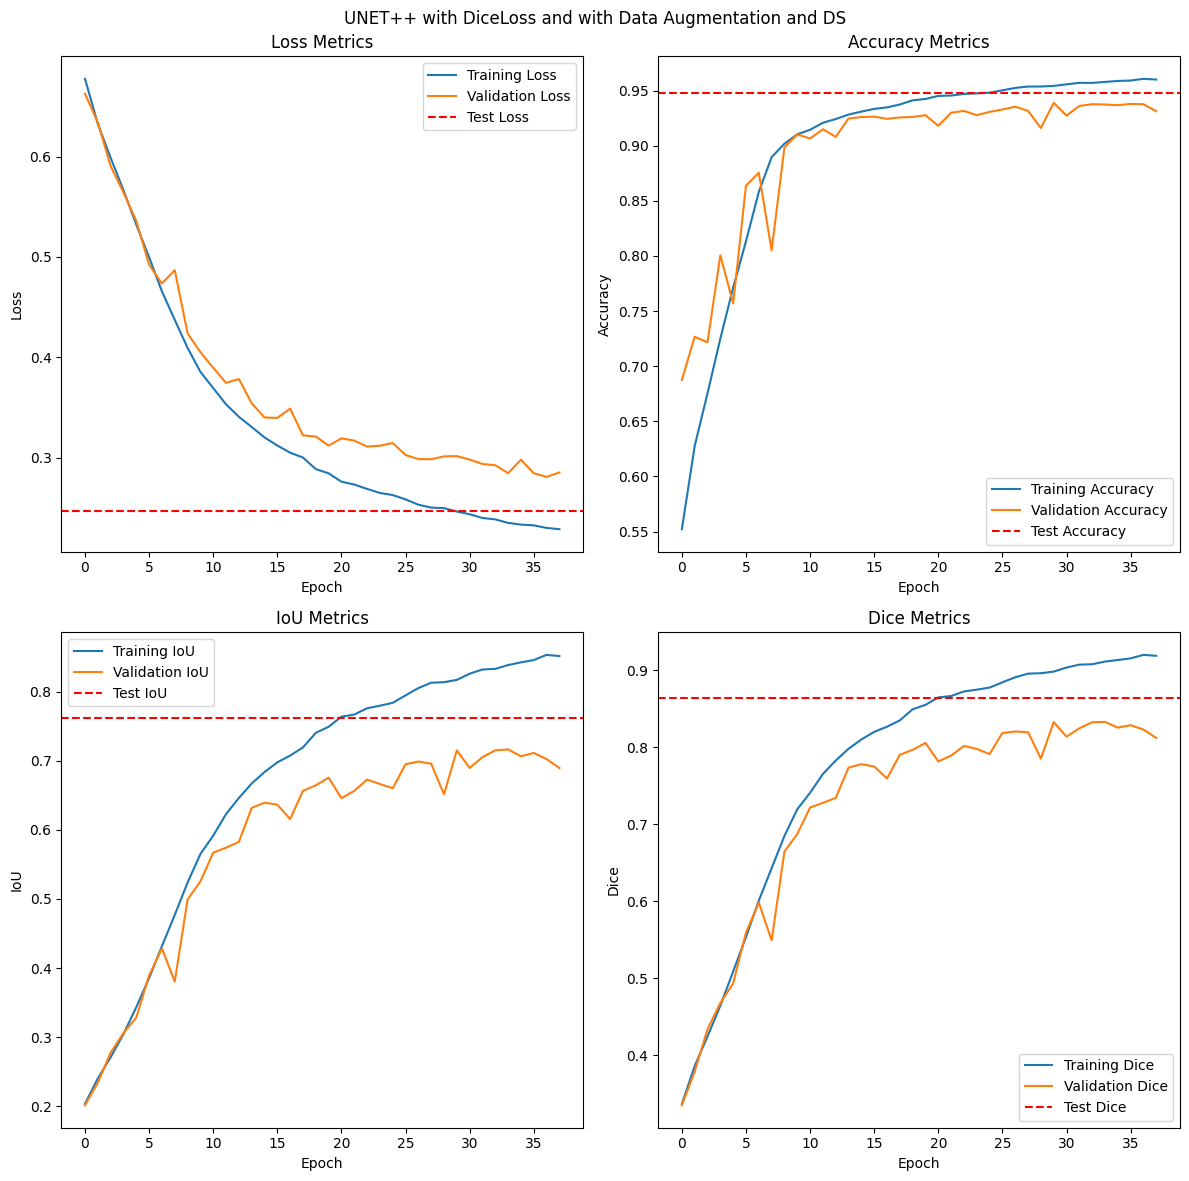

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('models/DiceLoss_try_Aug/log.csv')
test = pd.read_csv('models/DiceLoss_try_Aug/test_log.csv')

# Test values for loss, IoU, and Dice coefficients
test_loss = test['loss'].item()  
test_iou = test['iou'].item() 
test_dice = test['dice_coef'].item() 
test_accuracy = test['accuracy'].item() 

# Create a figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot the loss features in the first subplot
ax1.plot(df['epoch'], df['loss'], label='Training Loss')
ax1.plot(df['epoch'], df['val_loss'], label='Validation Loss')
ax1.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
ax1.annotate(f'{test_loss:.2f}', xy=(90, test_loss+0.005), color='r')
ax1.set_title('Loss Metrics')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(df['epoch'], df['accuracy'], label='Training Accuracy')
ax2.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
ax2.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
ax2.annotate(f'{test_accuracy:.2f}', xy=(90, test_accuracy+0.002), color='r')
ax2.set_title('Accuracy Metrics')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(df['epoch'], df['iou'], label='Training IoU')
ax3.plot(df['epoch'], df['val_iou'], label='Validation IoU')
ax3.axhline(y=test_iou, color='r', linestyle='--', label='Test IoU')
ax3.annotate(f'{test_iou:.2f}', xy=(90, test_iou+0.003), color='r')
ax3.set_title('IoU Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.legend()

ax4.plot(df['epoch'], df['dice'], label='Training Dice')
ax4.plot(df['epoch'], df['val_dice'], label='Validation Dice')
ax4.axhline(y=test_dice, color='r', linestyle='--', label='Test Dice')
ax4.annotate(f'{test_dice:.2f}', xy=(90, test_dice+0.005), color='r')
ax4.set_title('Dice Metrics')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice')
ax4.legend()

fig.suptitle("UNET++ with DiceLoss and with Data Augmentation and DS")
# Adjust the spacing between subplots
plt.tight_layout()

plt.savefig("results/DiceLoss_Aug_DS.png")
# Display the plot
plt.show()